# Real-time Load Forecasting and Resource Management - Advanced Modeling


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    tf_available = True
except ImportError:
    tf_available = False

plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## 1. Data loading and exploration

In [32]:
# Load the extended feature set data
data_path = '../processed_data/c7_user_fxHzmdZ_timeseries.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Successfully loaded data, shape: {df.shape}")
    
    # Display first few rows
    display(df.head())
    
    # View data types and basic information
    display(df.info())
    
    # View statistical summary of numerical features
    display(df.describe())
    
except Exception as e:
    print(f"Error reading data: {e}")

Successfully loaded data, shape: (2215, 5)


,user,time_dt,average_usage_cpu,average_usage_memory,hour
0,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.222809,0.005157,0.003006,1970-01-04 10:00:00
1,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:38:32.892376,0.005157,0.003006,1970-01-04 10:00:00
2,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:39:00.576619,0.005157,0.003006,1970-01-04 10:00:00
3,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:40:00.059573,0.005157,0.003006,1970-01-04 10:00:00
4,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,1970-01-04 10:52:14.119349,0.005157,0.003006,1970-01-04 10:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  2215 non-null   object 
 1   time_dt               2215 non-null   object 
 2   average_usage_cpu     2215 non-null   float64
 3   average_usage_memory  2215 non-null   float64
 4   hour                  2215 non-null   object 
dtypes: float64(2), object(3)
memory usage: 86.7+ KB


None

,average_usage_cpu,average_usage_memory
count,2215.000000,2.215000e+03
mean,0.003214,8.816644e-04
std,0.010281,1.274778e-03
min,0.000000,9.536743e-07
25%,0.000232,1.916885e-04
50%,0.000339,6.628036e-04
75%,0.001024,8.382797e-04
max,0.079346,9.140015e-03


### 1.1 Check for missing values

In [33]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

display(missing_df[missing_df['Missing Count'] > 0])

,Missing Count,Missing Percentage


### 1.2 Time feature inspection and transformation

In [34]:
# Check and transform time features
time_columns = [col for col in df.columns if 'time' in col.lower() and 'dt' not in col.lower()]
print(f"Time-related columns: {time_columns}")

for col in time_columns:
    if col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            df[f'{col}_dt'] = pd.to_datetime(df[col], unit='us')
            print(f"Converting column {col} to datetime format")

# Ensure time series index
if 'time_dt' in df.columns:
    # Set time column as index
    df_ts = df.set_index('time_dt').sort_index()
    print("Time column set as index and sorted")
    display(df_ts.head())
else:
    print("time_dt column not found, checking time column conversion")

Time-related columns: []
Time column set as index and sorted


,user,average_usage_cpu,average_usage_memory,hour
time_dt,,,,
1970-01-04 10:38:32.222809,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,0.005157,0.003006,1970-01-04 10:00:00
1970-01-04 10:38:32.892376,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,0.005157,0.003006,1970-01-04 10:00:00
1970-01-04 10:39:00.576619,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,0.005157,0.003006,1970-01-04 10:00:00
1970-01-04 10:40:00.059573,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,0.005157,0.003006,1970-01-04 10:00:00
1970-01-04 10:52:14.119349,fxHzmdZ8NxlpSAB2NMTz02oSA605plu5LH/Lvceltzs=,0.005157,0.003006,1970-01-04 10:00:00


### 1.3 The distribution of the target variable and visualization of the time series

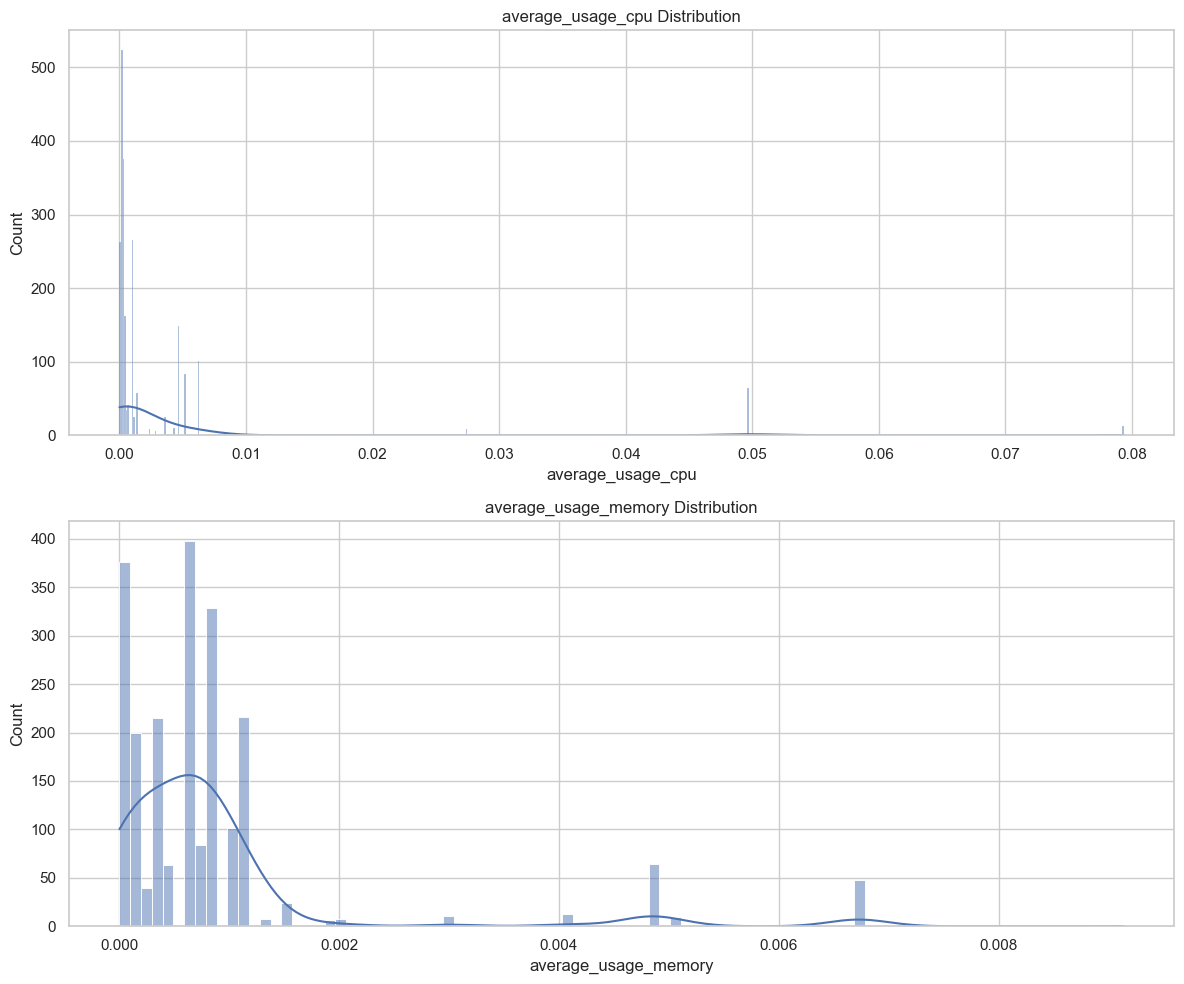

In [35]:
# Define target variables (CPU and memory usage)
target_vars = ['average_usage_cpu', 'average_usage_memory']

# Check if target variables exist
target_vars = [var for var in target_vars if var in df.columns]

if target_vars:
    # Visualize target variable distributions
    fig, axes = plt.subplots(len(target_vars), 1, figsize=(12, 5*len(target_vars)))
    if len(target_vars) == 1:
        axes = [axes]
        
    for i, var in enumerate(target_vars):
        # Histogram
        sns.histplot(df[var], ax=axes[i], kde=True)
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel(var)
    
    plt.tight_layout()
    plt.show()
    
    # Time series visualization
    #if 'time_dt' in df.columns:
    #    fig, axes = plt.subplots(len(target_vars), 1, figsize=(16, 6*len(target_vars)))
    #    if len(target_vars) == 1:
    #        axes = [axes]
            
    #    for i, var in enumerate(target_vars):
    #        axes[i].plot(df['time_dt'], df[var])
    #        axes[i].set_title(f'{var} Time Series')
    #        axes[i].set_xlabel('Time')
    #        axes[i].set_ylabel(var)
        
    #    plt.tight_layout()
    #    plt.show()
else:
    print("Target variables not found in dataset, please check column names")

## 2. Feature engineering

Based on the previous model results and data analysis, we will create more advanced features to enhance the model performance.

### 2.1 Creation of temporal characteristics

In [36]:
# Create time features
def create_time_features(df, time_col='time_dt'):
    """Create rich time features from time column"""
    print("\nCreating time features...")
    
    # Ensure column exists
    if time_col not in df.columns:
        print(f"Column {time_col} does not exist")
        return df
    
    # Copy dataframe to avoid modifying original data
    df_new = df.copy()
    
    # Ensure time column is datetime type
    df_new[time_col] = pd.to_datetime(df_new[time_col])
    print(f"Converting {time_col} to datetime type")
    
    # Create features from datetime
    df_new['hour_of_day'] = df_new[time_col].dt.hour
    df_new['day_of_week'] = df_new[time_col].dt.dayofweek
    df_new['day_of_month'] = df_new[time_col].dt.day
    df_new['month'] = df_new[time_col].dt.month
    
    # Create weekend indicator (0=weekday, 1=weekend)
    df_new['is_weekend'] = df_new['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create time of day classification
    def get_day_part(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'
    
    df_new['day_part'] = df_new['hour_of_day'].apply(get_day_part)
    
    # One-hot encode time periods
    df_new = pd.get_dummies(df_new, columns=['day_part'], prefix='day_part')
    
    # Create cyclical features for hour and date (sine and cosine transformations)
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour_of_day'] / 24)
    df_new['day_sin'] = np.sin(2 * np.pi * df_new['day_of_week'] / 7)
    df_new['day_cos'] = np.cos(2 * np.pi * df_new['day_of_week'] / 7)
    
    return df_new

# Apply time feature creation function
if 'time_dt' in df.columns:
    df = create_time_features(df)
    print("Time features created")
    
    # Display newly created time feature columns
    time_feature_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos']
    time_feature_cols = [col for col in time_feature_cols if col in df.columns]
    
    if time_feature_cols:
        display(df[time_feature_cols].head())
else:
    print("Cannot create time features, missing time_dt column")


Creating time features...
Converting time_dt to datetime type
Time features created


,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos
0,10,6,1,0.5,-0.866025
1,10,6,1,0.5,-0.866025
2,10,6,1,0.5,-0.866025
3,10,6,1,0.5,-0.866025
4,10,6,1,0.5,-0.866025


### 2.2 Sliding window feature (lag feature)

In [37]:
# Create lag features (based on sorted time series)
def create_lag_features(df, target_cols, lag_periods=[1, 3, 6, 12, 24], sort_col='time_dt'):
    """Create lag features for target columns"""
    # Ensure data is sorted by time
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # Create features for each target column and lag period
    for target in target_cols:
        for lag in lag_periods:
            # Create lag feature
            df_sorted[f'{target}_lag_{lag}'] = df_sorted[target].shift(lag)
    
    return df_sorted

# Create rolling window statistical features
def create_rolling_features(df, target_cols, windows=[3, 6, 12, 24], sort_col='time_dt'):
    """Create rolling window statistical features for target columns"""
    # Ensure data is sorted by time
    df_sorted = df.sort_values(by=sort_col).copy()
    
    # Create features for each target column and window
    for target in target_cols:
        for window in windows:
            # Create rolling mean
            df_sorted[f'{target}_rolling_mean_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).mean()
            # Create rolling standard deviation
            df_sorted[f'{target}_rolling_std_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).std()
            # Create rolling min and max
            df_sorted[f'{target}_rolling_min_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).min()
            df_sorted[f'{target}_rolling_max_{window}'] = df_sorted[target].rolling(window=window, min_periods=1).max()
    
    return df_sorted

# Apply lag and rolling window feature creation
if 'time_dt' in df.columns and target_vars:
    # Create lag features
    df = create_lag_features(df, target_vars)
    print("Lag features created")
    
    # Create rolling window features
    df = create_rolling_features(df, target_vars)
    print("Rolling window features created")
    
    # Display first few rows of new features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col][:5]
    if lag_cols:
        display(df[lag_cols].head(10))
else:
    print("Cannot create time series features, missing required columns")

Lag features created
Rolling window features created


,average_usage_cpu_lag_1,average_usage_cpu_lag_3,average_usage_cpu_lag_6,average_usage_cpu_lag_12,average_usage_cpu_lag_24
0,NaN,NaN,NaN,NaN,NaN
1,0.005157,NaN,NaN,NaN,NaN
2,0.005157,NaN,NaN,NaN,NaN
3,0.005157,0.005157,NaN,NaN,NaN
4,0.005157,0.005157,NaN,NaN,NaN
5,0.005157,0.005157,NaN,NaN,NaN
6,0.005157,0.005157,0.005157,NaN,NaN
7,0.005157,0.005157,0.005157,NaN,NaN
8,0.005157,0.005157,0.005157,NaN,NaN
9,0.005157,0.005157,0.005157,NaN,NaN


## 3. Prepare model training data

In [38]:
def prepare_data_for_modeling(df, target_vars):
    """Prepare data for model training"""
    print("\nPreparing data for model training...")
    
    # Handle missing values
    print("Handling missing values...")
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                # Fill numeric columns with median
                df[col] = df[col].fillna(df[col].median())
            else:
                # Fill non-numeric columns with mode
                df[col] = df[col].fillna(df[col].mode()[0])
    
    # Remove unnecessary columns
    cols_to_drop = []
    
    # Remove high-cardinality ID columns
    id_cols = [col for col in df.columns if 'id' in col.lower() or 'name' in col.lower() or 'user' in col.lower()]
    cols_to_drop.extend(id_cols)
    
    # Remove original timestamp columns (keep converted dt columns)
    timestamp_cols = [col for col in df.columns if ('time' in col.lower() and 'dt' not in col.lower())]
    cols_to_drop.extend(timestamp_cols)
    
    # Exclude target variables
    cols_to_drop = [col for col in cols_to_drop if col not in target_vars]
    
    # Remove columns that are all NaN
    null_cols = df.columns[df.isnull().all()].tolist()
    cols_to_drop.extend(null_cols)
    
    # Drop columns
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')
    print(f"Dropped {len(cols_to_drop)} columns")
    
    # Convert categorical variables to numeric
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        if col not in target_vars:  # Don't transform target variables
            # Label encode categorical variables
            df[col] = pd.factorize(df[col])[0]
    
    print("Data preparation completed")
    return df

df = prepare_data_for_modeling(df, target_vars)


Preparing data for model training...
Handling missing values...
Dropped 1 columns
Data preparation completed


### 4. Build a model for each target variable

In [39]:
def visualize_predictions_separate(y_true, predictions_dict, title_prefix="Prediction Comparison"):
    """Create a separate prediction vs true value comparison chart for each model"""
    
    # First, create an overview chart containing all models
    #plt.figure(figsize=(12, 6))
    #plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')
    
    #for model_name, preds in predictions_dict.items():
    #    plt.plot(range(len(preds)), preds, '--', label=f'{model_name} Prediction')
    
    #plt.title(f"{title_prefix} - Overview")
    #plt.xlabel('Time')
    #plt.ylabel('Target Value')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.savefig(f"{title_prefix.replace(' ', '_')}_overview.png")
    #plt.show()
    
    # Then, create a separate chart for each model
    for model_name, preds in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'k-', label='True Value')
        plt.plot(range(len(preds)), preds, 'r--', label=f'{model_name} Prediction')
        
        plt.title(f"{title_prefix} - {model_name}")
        plt.xlabel('Time')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig(f"{title_prefix.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.show()
    
    print(f"Created {len(predictions_dict) + 1} prediction comparison charts")

def evaluate_models(df, target_var, test_size=0.2, random_state=42):
    """Build and evaluate multiple prediction models"""
    print(f"\nEvaluating prediction models for {target_var}...")
    
    # Prepare features and target
    y = df[target_var]
    X = df.drop(columns=[col for col in df.columns if col in [target_var] or col.startswith('time_')])
    
    print(f"Feature count: {X.shape[1]}")
    print(f"Sample count: {X.shape[0]}")
    
    # Create training and test sets (time series split)
    # To ensure we don't use future data to predict the past, use the last test_size proportion as test set
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    
    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Model results storage
    model_results = []
    
    # 1. ARIMA model
    try:
        print("\nTraining ARIMA model...")
        # Simplified ARIMA, using only target variable time series
        model = ARIMA(y_train, order=(5,1,0))
        arima_model = model.fit()
        
        # Predict
        arima_preds = arima_model.forecast(steps=len(y_test))
        
        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_test, arima_preds))
        mae = mean_absolute_error(y_test, arima_preds)
        r2 = r2_score(y_test, arima_preds)
        
        print(f"ARIMA - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
        model_results.append({"model": "ARIMA", "rmse": rmse, "mae": mae, "r2": r2})
    except Exception as e:
        print(f"ARIMA model training failed: {e}")
    
    # 2. Random Forest
    print("\nTraining Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf.fit(X_train_scaled, y_train)
    
    # Predict
    rf_preds = rf.predict(X_test_scaled)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
    mae = mean_absolute_error(y_test, rf_preds)
    r2 = r2_score(y_test, rf_preds)
    
    print(f"Random Forest - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    model_results.append({"model": "Random Forest", "rmse": rmse, "mae": mae, "r2": r2})
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 feature importance:")
    print(feature_importance.head(10))
    
    # 3. XGBoost
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)
    xgb_model.fit(X_train_scaled, y_train)
    
    # Predict
    xgb_preds = xgb_model.predict(X_test_scaled)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
    mae = mean_absolute_error(y_test, xgb_preds)
    r2 = r2_score(y_test, xgb_preds)
    
    print(f"XGBoost - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    model_results.append({"model": "XGBoost", "rmse": rmse, "mae": mae, "r2": r2})
    
    # 4. LSTM 
    #if tf_available and len(X_train) > 50:  # Ensure there's enough data
    #    try:
    #        print("\nTraining LSTM model...")
            
    #        # Prepare LSTM input (samples, timesteps, features)
    #        LOOKBACK = 5
            
    #        def create_sequences(X, y, time_steps=LOOKBACK):
    #            X_seq, y_seq = [], []
    #            for i in range(len(X) - time_steps):
    #                X_seq.append(X[i:i + time_steps])
    #                y_seq.append(y[i + time_steps])
    #            return np.array(X_seq), np.array(y_seq)
            
    #        # Create sequences
    #        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values)
            
    #        # Build LSTM model
    #        model = Sequential([
    #            LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    #            Dropout(0.2),
    #            LSTM(50, activation='relu'),
    #            Dropout(0.2),
    #            Dense(1)
    #        ])
            
    #        model.compile(optimizer='adam', loss='mse')
            
    #        # Early stopping
    #        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
    #        # Train
    #        history = model.fit(
    #            X_train_seq, y_train_seq,
    #            epochs=50,
    #            batch_size=32,
    #            validation_split=0.2,
    #            callbacks=[early_stop],
    #            verbose=1
    #        )
            
    #        # Create sequences for test set
    #        X_full = np.vstack((X_train_scaled[-LOOKBACK:], X_test_scaled))
    #        X_test_seq = []
    #        for i in range(len(X_test)):
    #            X_test_seq.append(X_full[i:i + LOOKBACK])
    #        X_test_seq = np.array(X_test_seq)
            
    #        # Predict
    #        lstm_preds = model.predict(X_test_seq).flatten()
            
    #        # Evaluate
    #        rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
    #        mae = mean_absolute_error(y_test, lstm_preds)
    #        r2 = r2_score(y_test, lstm_preds)
            
    #        print(f"LSTM - RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")
    #        model_results.append({"model": "LSTM", "rmse": rmse, "mae": mae, "r2": r2})
        
    #    except Exception as e:
    #        print(f"LSTM model training failed: {e}")
    

    # Summarize results
    results_df = pd.DataFrame(model_results)
    results_df = results_df.sort_values('rmse')
    
    print("\nModel performance summary:")
    print(results_df)

    predictions_dict = {}
    if 'arima_preds' in locals():
        predictions_dict['ARIMA'] = arima_preds
    predictions_dict['Random Forest'] = rf_preds
    predictions_dict['XGBoost'] = xgb_preds
    if 'lstm_preds' in locals():
        predictions_dict['LSTM'] = lstm_preds

    # 可视化预测结果
    visualize_predictions_separate(
        y_true=y_test, 
        predictions_dict=predictions_dict,
        title_prefix=f"{target_var} Prediction Comparison"
    )
    
    # Return the best model and evaluation results
    return results_df, feature_importance



Evaluating prediction models for average_usage_cpu...
Feature count: 36
Sample count: 2215
Training set shape: (1772, 36), Test set shape: (443, 36)

Training ARIMA model...
ARIMA - RMSE: 0.009588, MAE: 0.003478, R²: -0.106699

Training Random Forest...
Random Forest - RMSE: 0.008604, MAE: 0.005659, R²: 0.108845

Top 10 feature importance:
                              feature  importance
0                average_usage_memory    0.829441
20   average_usage_cpu_rolling_mean_3    0.026597
22    average_usage_cpu_rolling_min_3    0.021419
23    average_usage_cpu_rolling_max_3    0.017282
28  average_usage_cpu_rolling_mean_12    0.014411
35   average_usage_cpu_rolling_max_24    0.013785
24   average_usage_cpu_rolling_mean_6    0.013741
31   average_usage_cpu_rolling_max_12    0.012658
27    average_usage_cpu_rolling_max_6    0.010664
18           average_usage_cpu_lag_12    0.007764

Training XGBoost...
XGBoost - RMSE: 0.004349, MAE: 0.001875, R²: 0.772359

Model performance summary:
    

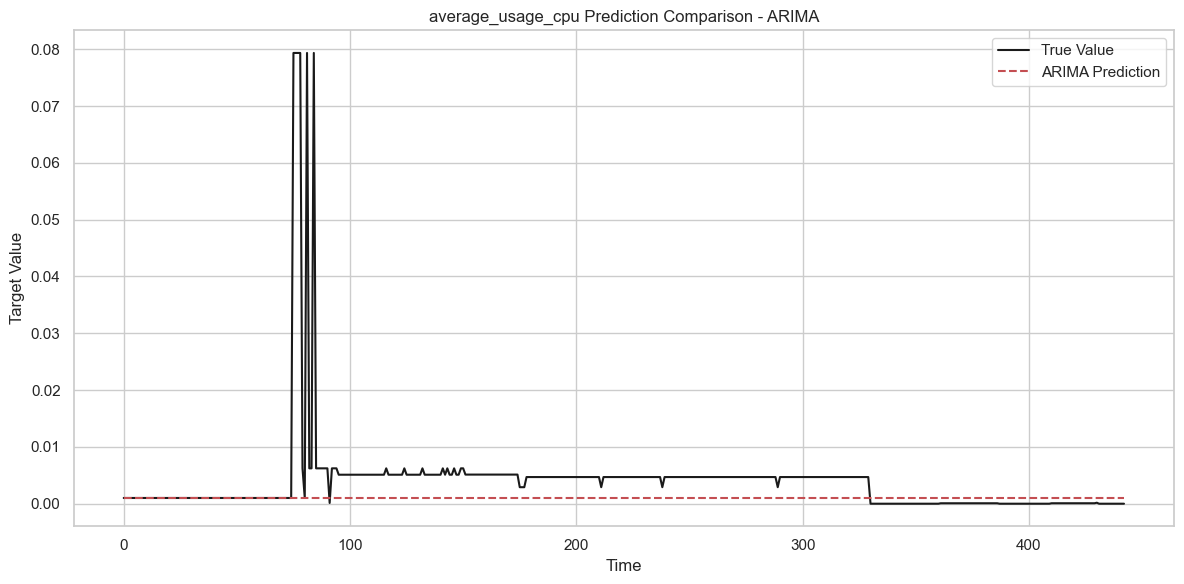

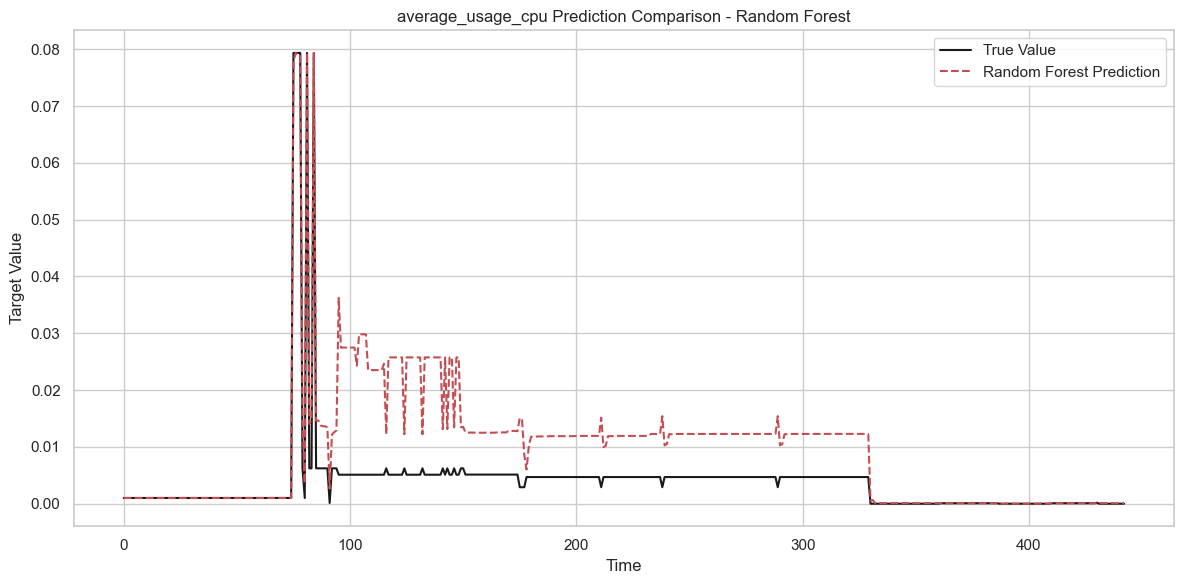

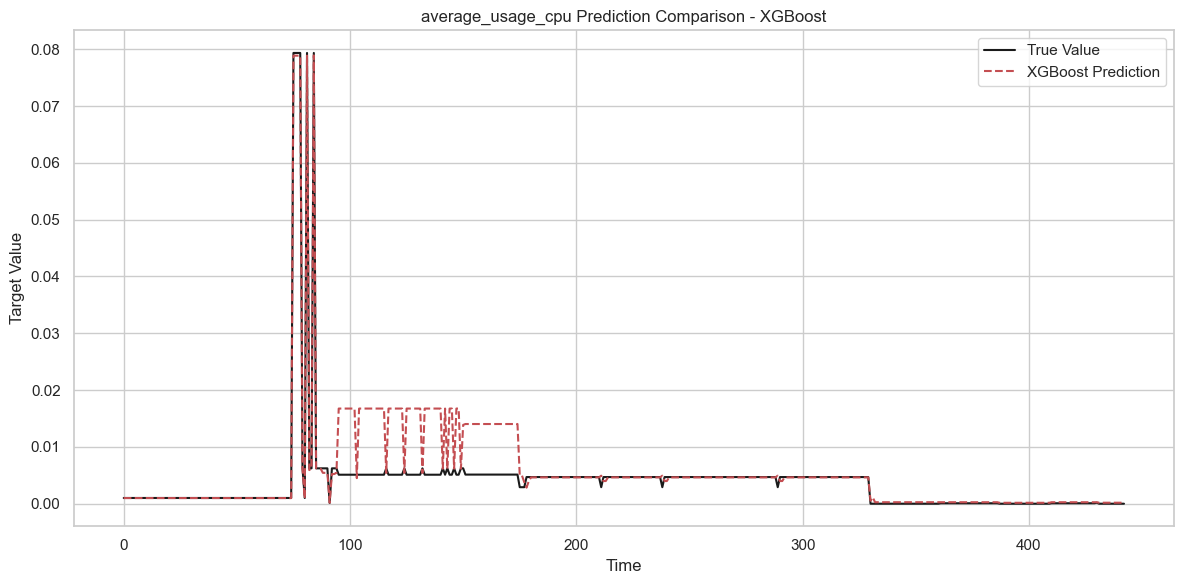

Created 4 prediction comparison charts

Evaluating prediction models for average_usage_memory...
Feature count: 36
Sample count: 2215
Training set shape: (1772, 36), Test set shape: (443, 36)

Training ARIMA model...
ARIMA - RMSE: 0.002308, MAE: 0.001257, R²: -0.401751

Training Random Forest...
Random Forest - RMSE: 0.001286, MAE: 0.000717, R²: 0.565124

Top 10 feature importance:
                                feature  importance
0                     average_usage_cpu    0.541311
20  average_usage_memory_rolling_mean_3    0.300743
22   average_usage_memory_rolling_min_3    0.059280
34  average_usage_memory_rolling_min_24    0.042140
23   average_usage_memory_rolling_max_3    0.006340
4                          day_of_month    0.005973
31  average_usage_memory_rolling_max_12    0.005356
1                                  hour    0.005208
35  average_usage_memory_rolling_max_24    0.004070
25   average_usage_memory_rolling_std_6    0.003085

Training XGBoost...
XGBoost - RMSE: 0.0022

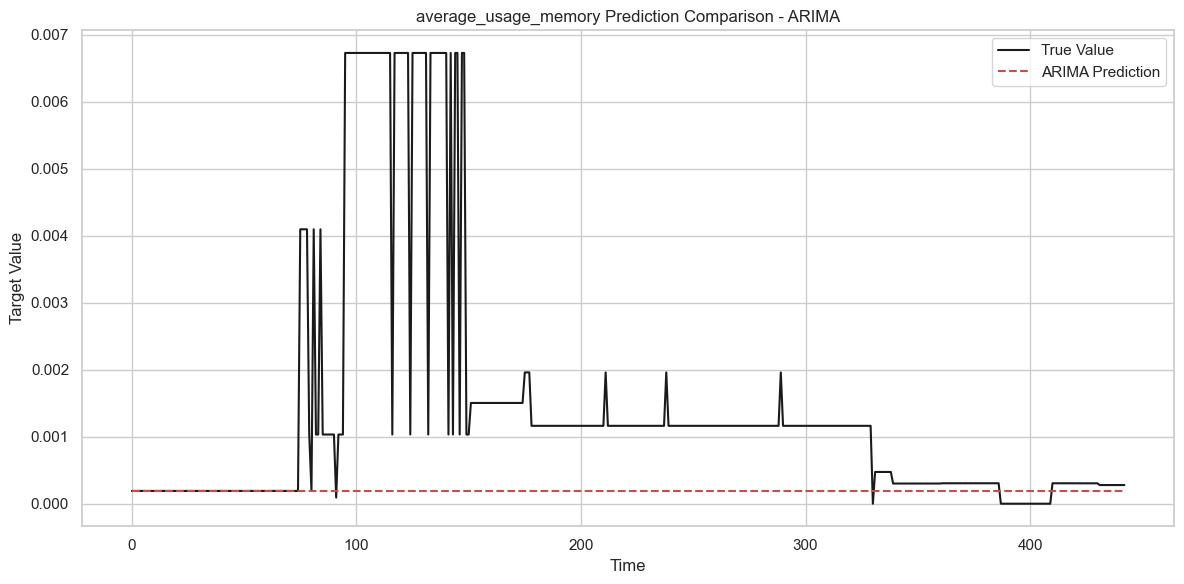

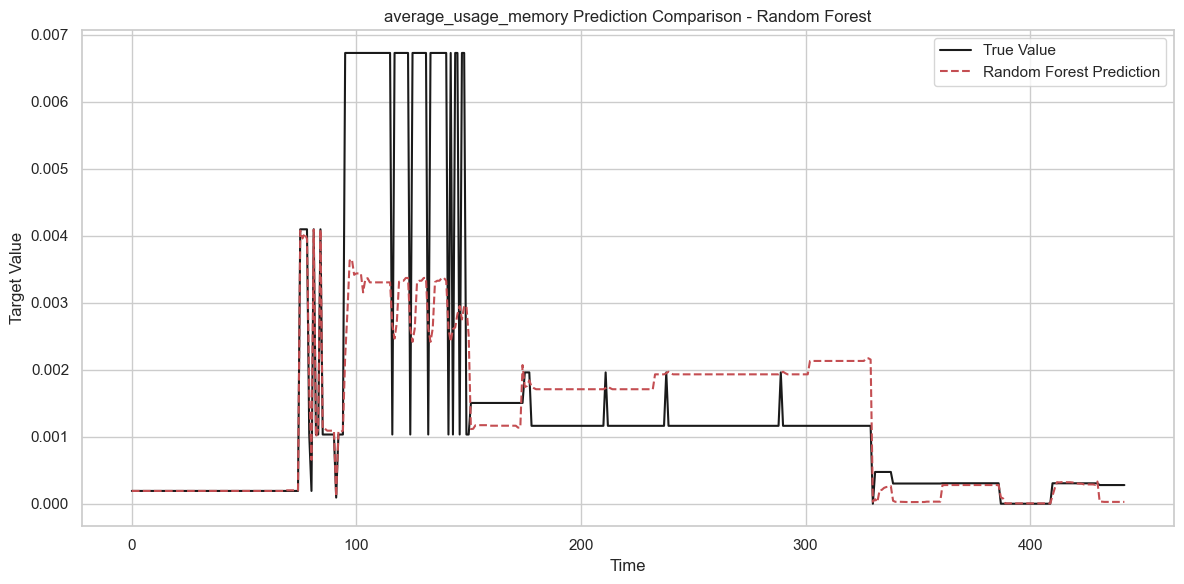

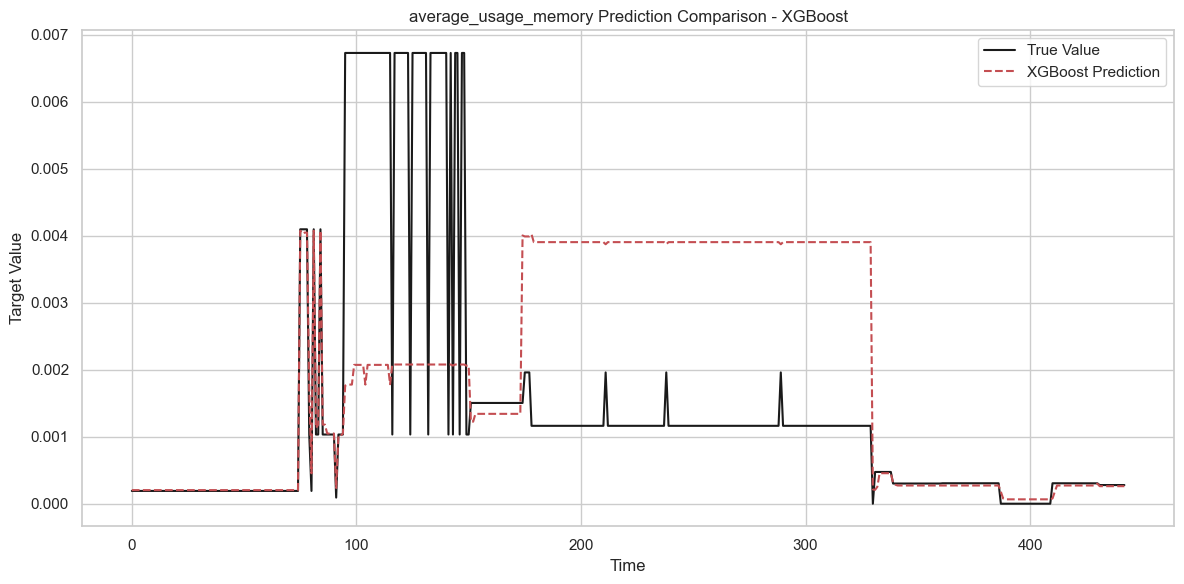

Created 4 prediction comparison charts
Modeling completed!


In [40]:
for target_var in target_vars:
    # Filter out rows with NaN values
    df_clean = df.dropna(subset=[target_var])
    
    # Filter out lag features of other target variables
    other_targets = [t for t in target_vars if t != target_var]
    cols_to_drop = []
    for other_target in other_targets:
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_lag_")])
        cols_to_drop.extend([col for col in df_clean.columns if col.startswith(f"{other_target}_rolling_")])
    
    df_model = df_clean.drop(columns=cols_to_drop, errors='ignore')
    
    # Build and evaluate models
    results_df, feature_importance = evaluate_models(df_model, target_var)
    
    # Save results
    #results_df.to_csv(f"model_results_{target_var}.csv", index=False)
    #feature_importance.to_csv(f"feature_importance_{target_var}.csv", index=False)

print("Modeling completed!")